# Set-up

**Install PyTorch and Torchvision.**

In [2]:
!pip install torch torchvision

# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
5.3.0


**Retrieve necessary files from repository.**

In [3]:
!rm -r *
!wget https://github.com/udacity/pytorch_challenge/archive/master.zip
!unzip master.zip
!mv pytorch_challenge-master/* .

--2019-01-02 12:50:09--  https://github.com/udacity/pytorch_challenge/archive/master.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/udacity/pytorch_challenge/zip/master [following]
--2019-01-02 12:50:09--  https://codeload.github.com/udacity/pytorch_challenge/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.253.121, 192.30.253.120
Connecting to codeload.github.com (codeload.github.com)|192.30.253.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [ <=>                ] 867.97K  5.23MB/s    in 0.2s    

2019-01-02 12:50:09 (5.23 MB/s) - ‘master.zip’ saved [888800]

Archive:  master.zip
52e37e55ba847539d8b83eacd049bbe6cfa70cf8
   creating: pytorch_challenge-master/
  inflating: 

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/Flowers.png?raw=1' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from google.colab import files

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

### Download the Data

In [6]:
!rm -r flower_data
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip 
!unzip flower_data.zip

rm: cannot remove 'flower_data': No such file or directory
--2019-01-02 12:53:39--  https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.163.37
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.163.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311442766 (297M) [application/zip]
Saving to: ‘flower_data.zip’

flower_data.zip     100%[===================>] 297.01M  96.0MB/s    in 3.2s    

2019-01-02 12:53:43 (91.8 MB/s) - ‘flower_data.zip’ saved [311442766/311442766]

Archive:  flower_data.zip
   creating: flower_data/
   creating: flower_data/valid/
   creating: flower_data/valid/61/
  inflating: flower_data/valid/61/image_06296.jpg  
  inflating: flower_data/valid/61/image_06293.jpg  
  inflating: flower_data/valid/61/image_06292.jpg  
  inflating: flower_data/valid/61/image_06261.jpg  
  inflating: flower_data/valid/61/image_06259.jpg  
  inflating: flower_data/vali

### Set-up Data Loaders

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
val_dir = data_dir + '/valid'

In [8]:
!ls
!ls flower_data

 assets		    flower_data.zip		      master.zip
 cat_to_name.json   gdrive			      pytorch_challenge-master
 flower_data	   'Image Classifier Project.ipynb'
train  valid


In [0]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32


# TODO: Define your transforms for the training and validation sets
# data_transforms = 


train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
#     transforms.Resize(40),
#     transforms.CenterCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([    
#     transforms.Resize(40),
#     transforms.CenterCrop(32),
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_data = datasets.ImageFolder(root=val_dir, transform=test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
# dataloaders = 


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)



In [0]:
# Count train and val

def count_total(data_loader):
  total = 0
  for data, labels in data_loader:
    total += data.size()[0]
  return total  
  
  
# train_total = count_total(train_loader)
# val_total = count_total(val_loader)
# total = train_total + val_total
# print(f"Train: {train_total} ({train_total/total * 100 : .2f}%)") #~8k
# print(f"Val:   {val_total} ({val_total/total * 100 : .2f}%)") #~600

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
    
int_to_name = {int(x): cat_to_name[x] for x in cat_to_name.keys()}

In [12]:
all_keys = sorted(list(cat_to_name.keys()))
print(f"Total Classes: {len(all_keys)}")

for key in all_keys[:5]:
  print(f"{key}: {cat_to_name[key]}")
  
# Note, keys are strings

Total Classes: 102
1: pink primrose
10: globe thistle
100: blanket flower
101: trumpet creeper
102: blackberry lily


### Visualizing the Data

In [0]:
# helper function to un-normalize and display an image
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

columbine


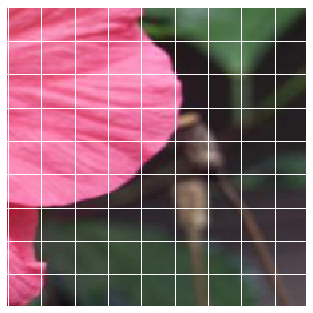

In [14]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# images = images.numpy() # convert images to numpy for display

# imshow(images[0], normalize=True)

fig = plt.figure()
for idx in np.arange(1):
    imshow(images[idx], normalize=True)
    print(cat_to_name[str(labels[idx].item())])

In [15]:
# For checking the classes in the dataset
species = sorted(cat_to_name.values())
print("\n".join(species))

alpine sea holly
anthurium
artichoke
azalea
ball moss
balloon flower
barbeton daisy
bearded iris
bee balm
bird of paradise
bishop of llandaff
black-eyed susan
blackberry lily
blanket flower
bolero deep blue
bougainvillea
bromelia
buttercup
californian poppy
camellia
canna lily
canterbury bells
cape flower
carnation
cautleya spicata
clematis
colt's foot
columbine
common dandelion
corn poppy
cyclamen
daffodil
desert-rose
english marigold
fire lily
foxglove
frangipani
fritillary
garden phlox
gaura
gazania
geranium
giant white arum lily
globe thistle
globe-flower
grape hyacinth
great masterwort
hard-leaved pocket orchid
hibiscus
hippeastrum
japanese anemone
king protea
lenten rose
lotus lotus
love in the mist
magnolia
mallow
marigold
mexican aster
mexican petunia
monkshood
moon orchid
morning glory
orange dahlia
osteospermum
oxeye daisy
passion flower
pelargonium
peruvian lily
petunia
pincushion flower
pink primrose
pink-yellow dahlia
poinsettia
primula
prince of wales feathers
purple cone

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

## VGG Pre-trained

In [16]:
vgg_model = models.vgg16(pretrained=True)
for param in vgg_model.parameters():
  param.requires_grad = False
vgg_model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:25<00:00, 22114423.71it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### Define FC for VGG


In [30]:
class MyClassifier(nn.Module):
  def __init__(self):
    super(MyClassifier, self).__init__()
    self.fc1 = nn.Linear(25088, 256)
    self.fc2 = nn.Linear(256, 102)
    self.dropout = nn.Dropout(0.2)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    
    x = F.log_softmax(self.fc2(x), dim=1)
    
    return x
    

vgg_model.classifier = MyClassifier()
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

### Code for Extracting only the Model

For submission purposes, it is faster to extract only the model to be uploaded to Udacity's submission workspace.

In [0]:
# Load Classifier
ROOT_DIR = 'gdrive/My Drive/flower_models/VGG Pretrained'

state_dict = torch.load(f'{ROOT_DIR}/model_flowers_8_0.3054.tar')
vgg_model.load_state_dict(state_dict['model'])

torch.save(vgg_model.classifier.state_dict(), f'{ROOT_DIR}/vgg_model_sgd_dropout_8_0.3054.pt')

## From Scratch

This is to compare the performance of using a pre-trained network with one you create and train from scratch.

In [0]:

# define the CNN architecture
class ScratchNet(nn.Module):
    def __init__(self):
        super(ScratchNet, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 102)
        
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten
        x = x.view(x.shape[0], -1)
        
        # FC layers
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

personal_model = ScratchNet()
# If you want to load saved weights
# personal_model.load_state_dict(torch.load('gdrive/My Drive/flower_models/model_flowers_0.0188.pt'))

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

## Training Code

In [0]:
def run_model(model, data_loader, device, criterion, optimizer=None, print_every=None):
  
  # Determine if train mode
  if optimizer is None:
    is_train = False
  else:
    is_train = True
   
  # Switch modes accordingly
  if is_train: 
    model.train()
  else: 
    model.eval()
  
  total_loss = 0
  total_instances = 0

  print(f"Train Mode: {is_train}")
  for batch_num, (data, labels) in enumerate(data_loader):
    
    data, labels = data.to(device), labels.to(device)
    output = model.forward(data)
    batch_loss = criterion(output, labels)
    
    if is_train:
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
      
    curr_batch_size = data.size()[0]
    total_loss += batch_loss.item() * curr_batch_size
    total_instances += curr_batch_size
    
    if print_every and batch_num % print_every == 0:
      print(f"Batch {batch_num}: Loss={batch_loss:.2f}")

  avg_loss = total_loss / total_instances
  
  return avg_loss



min_val_loss = np.Inf

In [32]:
### Choose one to train ###
model = vgg_model
# model = personal_model

criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

EPOCHS = 10
PRINT_EVERY = 20
SAVE_DIR = 'gdrive/My Drive/flower_models/VGG Pretrained'

model = model.to(device)


for epoch in range(1, EPOCHS+1):
  
  print(f"Epoch {epoch}")
  
  train_loss = run_model(model, 
                         train_loader, 
                         device, 
                         criterion, 
                         optimizer=optimizer,
                         print_every=PRINT_EVERY)
  
  val_loss = run_model(model, 
                       val_loader, 
                       device, 
                       criterion, 
                       optimizer=None,
                       print_every=PRINT_EVERY)
  
  
  print(f"Epoch {epoch}: Train Loss={train_loss:.2f}, Val Loss={val_loss:.2f}")
  
  # save model if validation loss has decreased
  if val_loss <= min_val_loss:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(min_val_loss, val_loss))
    
    # Update Min Val Loss
    min_val_loss = val_loss
    
    # Save State
    file_name = f"model_flowers_{epoch}_{val_loss:.4f}.tar"
    
    save_dict = {
        'model': model.state_dict(),
        'epoch': epoch,
        'optimizer': optimizer.state_dict(),
        'min_val_loss': val_loss
    }
    
    torch.save(save_dict, f'{SAVE_DIR}/{file_name}')
    

Epoch 1
Train Mode: True
Batch 0: Loss=4.68
Batch 20: Loss=4.29
Batch 40: Loss=4.24
Batch 60: Loss=3.37
Batch 80: Loss=3.63
Batch 100: Loss=2.95
Batch 120: Loss=2.76
Batch 140: Loss=2.63
Batch 160: Loss=2.51
Batch 180: Loss=2.29
Batch 200: Loss=2.25
Train Mode: False
Batch 0: Loss=1.38
Batch 20: Loss=1.20
Epoch 1: Train Loss=3.14, Val Loss=1.49
Validation loss decreased (inf --> 1.490847).  Saving model ...
Epoch 2
Train Mode: True
Batch 0: Loss=1.82
Batch 20: Loss=1.80
Batch 40: Loss=2.35
Batch 60: Loss=1.24
Batch 80: Loss=1.73
Batch 100: Loss=1.06
Batch 120: Loss=1.34
Batch 140: Loss=1.59
Batch 160: Loss=1.57
Batch 180: Loss=1.23
Batch 200: Loss=0.97
Train Mode: False
Batch 0: Loss=0.94
Batch 20: Loss=0.74
Epoch 2: Train Loss=1.60, Val Loss=0.80
Validation loss decreased (1.490847 --> 0.797952).  Saving model ...
Epoch 3
Train Mode: True
Batch 0: Loss=1.38
Batch 20: Loss=0.99
Batch 40: Loss=1.31
Batch 60: Loss=1.44
Batch 80: Loss=1.30
Batch 100: Loss=1.19
Batch 120: Loss=1.29
Batch 1

In [0]:
!ls 'gdrive/My Drive/flower_models'

model_flowers_0.0188.pt  model_flowers_0.4314.pt  model_flowers_1.5534.pt
model_flowers_0.0236.pt  model_flowers_0.4463.pt  model_flowers_1.6040.pt
model_flowers_0.0280.pt  model_flowers_0.4769.pt  model_flowers_1.6699.pt
model_flowers_0.0522.pt  model_flowers_0.4866.pt  model_flowers_1.6754.pt
model_flowers_0.0574.pt  model_flowers_0.5591.pt  model_flowers_1.7453.pt
model_flowers_0.0638.pt  model_flowers_0.6136.pt  model_flowers_1.7975.pt
model_flowers_0.0652.pt  model_flowers_0.6522.pt  model_flowers_1.8461.pt
model_flowers_0.0781.pt  model_flowers_0.6870.pt  model_flowers_1.9172.pt
model_flowers_0.0864.pt  model_flowers_0.7348.pt  model_flowers_2.0019.pt
model_flowers_0.0974.pt  model_flowers_0.7602.pt  model_flowers_2.0664.pt
model_flowers_0.1156.pt  model_flowers_0.8232.pt  model_flowers_2.0925.pt
model_flowers_0.1312.pt  model_flowers_0.8357.pt  model_flowers_2.1837.pt
model_flowers_0.1316.pt  model_flowers_0.8579.pt  model_flowers_2.2788.pt
model_flowers_0.1447.pt  model_flowers

In [0]:
from google.colab import files
files.download("model_flowers_3.74.pt.zip")

## Accurracy

In [35]:
N_CLASSES = 102
classes = [cat_to_name[str(x)] for x in range(1, N_CLASSES+1)]

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(N_CLASSES))
class_total = list(0. for i in range(N_CLASSES))

model.eval()
# iterate over test data
for data, target in val_loader:
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(val_loader.dataset)
print('Val Loss: {:.6f}\n'.format(test_loss))

for i in range(N_CLASSES):
    if class_total[i] > 0:
        print('Val Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Val Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nVal Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Val Loss: 0.305372

Val Accuracy of pink primrose: 75% ( 6/ 8)
Val Accuracy of hard-leaved pocket orchid: 100% ( 4/ 4)
Val Accuracy of canterbury bells: 100% ( 6/ 6)
Val Accuracy of sweet pea: 80% ( 4/ 5)
Val Accuracy of english marigold: 100% ( 6/ 6)
Val Accuracy of tiger lily: 100% (10/10)
Val Accuracy of moon orchid: 100% ( 5/ 5)
Val Accuracy of bird of paradise: 100% ( 5/ 5)
Val Accuracy of monkshood: 100% ( 1/ 1)
Val Accuracy of globe thistle: 100% ( 7/ 7)
Val Accuracy of snapdragon: 100% ( 2/ 2)
Val Accuracy of colt's foot: 93% (15/16)
Val Accuracy of king protea: 90% (10/11)
Val Accuracy of spear thistle: 100% ( 4/ 4)
Val Accuracy of yellow iris: 100% ( 6/ 6)
Val Accuracy of globe-flower: 57% ( 4/ 7)
Val Accuracy of purple coneflower: 75% ( 3/ 4)
Val Accuracy of peruvian lily: 100% ( 8/ 8)
Val Accuracy of balloon flower: 100% (12/12)
Val Accuracy of giant white arum lily: 100% ( 5/ 5)
Val Accuracy of fire lily: 100% ( 2/ 2)
Val Accuracy of pincushion flower: 100% ( 3/ 3)
Val Acc

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='https://github.com/udacity/pytorch_challenge/blob/master/assets/inference_example.png?raw=1' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image, model, topk=5):
  ''' Predict the class (or classes) of an image using a trained deep learning model.
  '''
    
  # Evaluation config
  model.cpu()
  model.eval()

  # Inference
  with torch.no_grad():
    image = images[0].unsqueeze(dim=0)
    output = model.forward(image)
    probs = torch.exp(output)


    top_probs, top_classes = probs.topk(topk, dim=1)
    top_class_labels = [cat_to_name[str(x.item())] for x in top_classes[0]]

    top_probs_strings = [f"{x.item():.6f}" for x in top_probs[0]]
    print(top_probs_strings)
    print(top_class_labels)
    print(top_classes.numpy())

    prob_vals, preds_tensor = torch.max(probs, 1)


    print("\nClassification: {} ({:.6f})".format(cat_to_name[str(preds_tensor.item())], prob_vals.item()))
    
    imshow(image.squeeze(dim=0))


['0.908126', '0.023388', '0.013895', '0.009953', '0.009251']
['bishop of llandaff', 'english marigold', 'sword lily', 'orange dahlia', 'petunia']
[[56  5 43 59 51]]

Classification: bishop of llandaff (0.908126)
Correct Label: bishop of llandaff


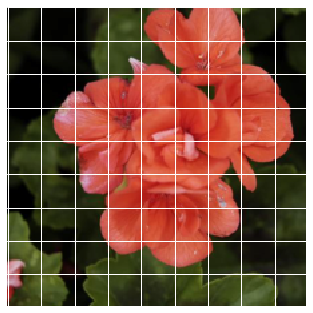

In [42]:
# obtain one batch of test images
dataiter = iter(val_loader)
images, labels = dataiter.next()
images.numpy()

predict(images[0], model)
print(f"Correct Label: {cat_to_name[str(labels[0].item())]}")
